# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import random
import math

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

def qrack_qft(sim, n):
    sim.iqft([i for i in reversed(range(n))])
    reverse_qrack(sim)
    sim.m_all()

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_0_qrack(n):
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    qrack_qft(sim, n)

    return time.perf_counter() - start

# Load OpenCL to avoid 1-sample discontinuity:
bench_0_qrack(27)

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_qrack(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 4.2221199987579896e-05, 2: 6.980869999324568e-05, 3: 8.486219999213063e-05, 4: 0.00013003789998720095, 5: 0.00014713070002017047, 6: 0.0001456698000083634, 7: 0.00017108189997543376, 8: 0.00018983820001494678, 9: 0.0002279100000123435, 10: 0.00025236670002186655, 11: 0.00037646559998165684, 12: 0.000507042399999591, 13: 0.0005274997000128678, 14: 0.0005546752000100241, 15: 0.0007250901999896087, 16: 0.0007497550000039154, 17: 0.0008210057999690435, 18: 0.0009038520000103744, 19: 0.0010259002999760014, 20: 0.0011185102000240477, 21: 0.0012542015999997603, 22: 0.0013592580000022282, 23: 0.0013916354000230058, 24: 0.001557553499981168, 25: 0.0014698083000212136, 26: 0.0016051368000034928, 27: 0.0016794244000038817}


### GHZ state initialization

In [5]:
def bench_ghz_qrack(n):
    start = time.perf_counter()
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    qrack_qft(sim, n)

    return time.perf_counter() - start

qrack_ghz_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_qrack(n))

    qrack_ghz_results[n] = sum(width_results) / samples

print(qrack_ghz_results)

{1: 9.876670001176535e-05, 2: 9.217040001203713e-05, 3: 0.0001734145999989778, 4: 0.00018325829998957487, 5: 0.00024245290003364062, 6: 0.0002893700999834437, 7: 0.0003223379000360183, 8: 0.00038804770000524515, 9: 0.00047230869998884375, 10: 0.0006692477999877156, 11: 0.0017859186000123372, 12: 0.0022510787999976854, 13: 0.0023964405999890915, 14: 0.002839719500002502, 15: 0.003091756099968279, 16: 0.0033786092000013925, 17: 0.0037248514000111756, 18: 0.004148617900023055, 19: 0.005085505999988982, 20: 0.008904055299990433, 21: 0.016775705399982143, 22: 0.03040861770001584, 23: 0.05609402920000548, 24: 0.11423157559999027, 25: 0.23438091030000124, 26: 0.4745868478000034, 27: 0.9490685148999887}


## FFTW ("Classical" DFT)

In [6]:
import pyfftw
import numpy as np

# See https://blog.hpc.qmul.ac.uk/pyfftw.html
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

### |0> initialization

In [7]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        start = time.perf_counter()
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 8.891780003068561e-05, 2: 3.46530999991046e-05, 3: 3.3205400018232464e-05, 4: 3.6998400037191456e-05, 5: 4.0319699974133985e-05, 6: 0.0001261270999862063, 7: 3.896570000279098e-05, 8: 3.720339999517819e-05, 9: 3.9082299986148426e-05, 10: 4.072520000590885e-05, 11: 4.777430002604888e-05, 12: 6.30162999982531e-05, 13: 0.00011207009998770445, 14: 0.00018685260001802818, 15: 0.0003572690999817496, 16: 0.0007595947999675445, 17: 0.0015972499000099561, 18: 0.0025556407000067336, 19: 0.008219908000000942, 20: 0.016724800300005428, 21: 0.013975530699963202, 22: 0.04561317259997395, 23: 0.09948239550000153, 24: 0.19776730679999446, 25: 0.37831153940002193, 26: 0.8626840643999912, 27: 1.7681662899999993}


### GHZ initialization

In [8]:
fftw_ghz_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        start = time.perf_counter()
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1. / math.sqrt(2.)
        io_array[(1 << n) - 1] = 1. / math.sqrt(2.)
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_ghz_results[n] = sum(width_results) / samples

print(fftw_ghz_results)

{1: 5.214099998056554e-05, 2: 2.8331400017123087e-05, 3: 2.021760000161521e-05, 4: 2.01524999852154e-05, 5: 2.2653300004549237e-05, 6: 2.298370001199146e-05, 7: 2.059290001170666e-05, 8: 2.372940000441304e-05, 9: 2.2824199982096614e-05, 10: 2.9773300002489123e-05, 11: 2.8328200005489635e-05, 12: 3.823379997811571e-05, 13: 7.109890000265296e-05, 14: 0.00010399869996717826, 15: 0.00017932300003167256, 16: 0.0003883273000042209, 17: 0.0008497734999991735, 18: 0.0018656771999872035, 19: 0.007617464899999505, 20: 0.01607951219999677, 21: 0.01138440009998476, 22: 0.04219138730001078, 23: 0.0961056074000112, 24: 0.18667001150000714, 25: 0.3560272474000044, 26: 0.8451011106999999, 27: 1.713565702599999}


## Qiskit Aer

In [9]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
# (See https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
def aer_qft(n, circuit):
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        circuit.cp(math.pi/2**(n-qubit), qubit, n)

    # Recursive QFT is very similiar to a ("classical") FFT
    aer_qft(n, circuit)

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

### |0> initialization

In [10]:
def bench_0_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_aer(n))

    aer_0_results[n] = sum(width_results) / samples

print(aer_0_results)

{1: 0.004917877699972451, 2: 0.0037653331000342405, 3: 0.004434207599979345, 4: 0.005136776300037127, 5: 0.005797317500002919, 6: 0.006524393600000167, 7: 0.007225818000017625, 8: 0.008142319599994608, 9: 0.008956375899992963, 10: 0.010174624400019639, 11: 0.010837479999997868, 12: 0.012543971000002329, 13: 0.01426066639999135, 14: 0.01537019020001935, 15: 0.016059876599979362, 16: 0.019329382799992346, 17: 0.0191033043000175, 18: 0.022670707200006746, 19: 0.024078403000009983, 20: 0.030039317600017056, 21: 0.04423925009998584, 22: 0.06142988610000657, 23: 0.10857875760000298, 24: 0.20150008759998173, 25: 0.3901074787000084, 26: 0.8001147277999963, 27: 1.7020083451000119}


### GHZ initialization

In [11]:
def bench_ghz_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    circ.h(0)
    for i in range(1, n):
        circ.cnot(0, i)
    aer_qft(num_qubits, circ)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_ghz_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_aer(n))

    aer_ghz_results[n] = sum(width_results) / samples

print(aer_ghz_results)

{1: 0.005788101899997855, 2: 0.0073146622000081155, 3: 0.007436083399989002, 4: 0.00757818650002946, 5: 0.007815206700001909, 6: 0.008080769900004725, 7: 0.008467674599990005, 8: 0.008846894299983888, 9: 0.00978648149999799, 10: 0.013281547899998714, 11: 0.012231990399970982, 12: 0.013400309799999377, 13: 0.014231888299968886, 14: 0.01549804259997245, 15: 0.017384674399988854, 16: 0.021271783600013805, 17: 0.02073225500001854, 18: 0.02556216680001171, 19: 0.027478038699985063, 20: 0.03749355130001959, 21: 0.05149920570001996, 22: 0.08062201790002063, 23: 0.13932366379999622, 24: 0.2678631570000107, 25: 0.5369357415000195, 26: 1.1121375904999808, 27: 2.3368173262999905}


## Qulacs

In [12]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

# Implementation of the Quantum Fourier Transform
# (See https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
def qulacs_qft(n, circ):
    if n == 0:
        return circ
    n -= 1

    circ.add_gate(qulacs.gate.H(n))
    for qubit in range(n):
        mat = get_rotz(math.pi/2**(n-qubit))
        gate = qulacs.gate.DenseMatrix(n, mat)
        gate.add_control_qubit(qubit, 1)
        circ.add_gate(gate)

    # Recursive QFT is very similiar to a ("classical") FFT
    qulacs_qft(n, circ)

### |0> initialization

In [13]:
def bench_0_qulacs(n):
    start = time.perf_counter()

    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    qulacs_qft(n, circ)
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))
    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_qulacs(n))

    qulacs_0_results[n] = sum(width_results) / samples

print(qulacs_0_results)

{1: 0.0026492142999927637, 2: 0.0008389772999862543, 3: 0.0007794185000079779, 4: 0.000896778599985737, 5: 0.0008305737999876328, 6: 0.0010240057999908458, 7: 0.0011900385999979335, 8: 0.001437480099991717, 9: 0.0017032433999588648, 10: 0.0019969288000197595, 11: 0.0023419590000003155, 12: 0.0029452251999941836, 13: 0.00348124040001494, 14: 0.0038125562999994146, 15: 0.004328094900006363, 16: 0.00684148880001203, 17: 0.01079984659999127, 18: 0.0150931241999956, 19: 0.024748020700008054, 20: 0.04392147509998949, 21: 0.08559313270000075, 22: 0.16977829839999004, 23: 0.3413117818999922, 24: 0.6840016043000219, 25: 1.361447382499989, 26: 2.7417311041999826, 27: 5.733884397599991}


### GHZ initialization

In [14]:
def bench_ghz_qulacs(n):
    start = time.perf_counter()
    
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    
    circ.add_gate(qulacs.gate.H(0))
    for i in range(1, n):
        circ.add_gate(qulacs.gate.CNOT(0, i))

    qulacs_qft(n, circ)
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_ghz_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_qulacs(n))

    qulacs_ghz_results[n] = sum(width_results) / samples

print(qulacs_ghz_results)

{1: 0.0012023780000049555, 2: 0.0014347431000146572, 3: 0.00163321590000578, 4: 0.001842824999982895, 5: 0.0014645246999862138, 6: 0.001437007000004087, 7: 0.0016308141000081378, 8: 0.001980975399987983, 9: 0.0022938825000096584, 10: 0.00242439559997365, 11: 0.0029921486000148434, 12: 0.0037804772999948, 13: 0.0041009183000142, 14: 0.004658242199991491, 15: 0.004995791899978031, 16: 0.007506975400019655, 17: 0.01128490389999115, 18: 0.015305127199985691, 19: 0.02491805279998971, 20: 0.04522968499999251, 21: 0.08958995360001154, 22: 0.17867066840000234, 23: 0.3647573271000283, 24: 0.7235270757999729, 25: 1.4221004169999787, 26: 2.9538904679999405, 27: 5.947420275500031}


## QCGPU

In [15]:
%env PYOPENCL_CTX 1

import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
# (See https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
def qcgpu_qft(n, circuit):
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(qubit, n, math.pi/2**(n-qubit))

    # Recursive QFT is very similiar to a ("classical") FFT
    qcgpu_qft(n, circuit)

env: PYOPENCL_CTX=1


### |0> initialization

In [16]:
def bench_0_qcgpu(num_qubits):
    start = time.perf_counter()
    state = qcgpu.State(num_qubits)
    qcgpu_qft(num_qubits, state)
    reverse_qcgpu(num_qubits, state)
    state.measure()
    state.backend.queue.finish()

    return time.perf_counter() - start

qcgpu_0_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_0_qcgpu(n))

    qcgpu_0_results[n] = sum(width_results) / samples

print(qcgpu_0_results)

{1: 0.007799616200009041, 2: 0.0019336088000045492, 3: 0.002618007299975034, 4: 0.004323311699999976, 5: 0.005132512199952544, 6: 0.006736462499929985, 7: 0.007729649100042479, 8: 0.009256468499984294, 9: 0.010632770799975332, 10: 0.01305104460000166, 11: 0.015522839100003693, 12: 0.01845734209998682, 13: 0.02106738549994134, 14: 0.02445042590002231, 15: 0.027567394199991213, 16: 0.03173543949997111, 17: 0.035601053000004865, 18: 0.04103714099999252, 19: 0.047812779199989566, 20: 0.05784816099996988, 21: 0.07544933750007203, 22: 0.10395306129998971, 23: 0.1760224586000277, 24: 0.36438075239998396, 25: 0.7523188178000282, 26: 1.5643833017999895, 27: 3.2367843248999635}


### GHZ initialization

In [17]:
def bench_ghz_qcgpu(num_qubits):
    start = time.perf_counter()
    state = qcgpu.State(num_qubits)
    state.h(0)
    for i in range(1, num_qubits):
        state.cnot(0, i)
    qcgpu_qft(num_qubits, state)
    reverse_qcgpu(num_qubits, state)
    state.measure()
    state.backend.queue.finish()

    return time.perf_counter() - start

qcgpu_ghz_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_ghz_qcgpu(n))

    qcgpu_ghz_results[n] = sum(width_results) / samples

print(qcgpu_ghz_results)

{1: 0.0015715783999894484, 2: 0.0017039967000528123, 3: 0.0023541831999864373, 4: 0.003717023500007599, 5: 0.004870253999979468, 6: 0.006465151699990202, 7: 0.00799307089996546, 8: 0.01016243200003828, 9: 0.012072342999977082, 10: 0.014712978600027782, 11: 0.017030851499976053, 12: 0.020047675500040895, 13: 0.022953919799942924, 14: 0.026448590599989073, 15: 0.02988212869997824, 16: 0.03387691879997874, 17: 0.03821301689999927, 18: 0.04397342979991663, 19: 0.050701341099988896, 20: 0.06099235940002927, 21: 0.07884681709999768, 22: 0.10760825709999153, 23: 0.18348263909997514, 24: 0.38035064279999914, 25: 0.784704212299971, 26: 1.6319878768000309, 27: 3.37908313370001}


## qsimcirq

### |0> initialization

In [18]:
# See ../scripts/qsimcirq_qft.py
# We run that file on the cuQuantum appliance.

qsimcirq_0_results = {1: 0.07385765479999976, 2: 0.0015780337999984795, 3: 0.0016430338000077427, 4: 0.0018144266999968294, 5: 0.002084060699999668, 6: 0.002407896100001494, 7: 0.002758264100000929, 8: 0.0031870388000044157, 9: 0.0036087892000011834, 10: 0.004559571500007564, 11: 0.004639045599998326, 12: 0.005286043700002097, 13: 0.005869240800004149, 14: 0.006546703799997999, 15: 0.00726734149999686, 16: 0.008072268600000144, 17: 0.008913285200003429, 18: 0.010151747300002966, 19: 0.012265966199996115, 20: 0.019659469999999145, 21: 0.030686679299998333, 22: 0.05367884720000404, 23: 0.10213243340000133, 24: 0.206353410600002, 25: 0.4277628598999996, 26: 0.9024525450000056, 27: 1.9176354973000058}
print(qsimcirq_0_results)

{1: 0.07385765479999976, 2: 0.0015780337999984795, 3: 0.0016430338000077427, 4: 0.0018144266999968294, 5: 0.002084060699999668, 6: 0.002407896100001494, 7: 0.002758264100000929, 8: 0.0031870388000044157, 9: 0.0036087892000011834, 10: 0.004559571500007564, 11: 0.004639045599998326, 12: 0.005286043700002097, 13: 0.005869240800004149, 14: 0.006546703799997999, 15: 0.00726734149999686, 16: 0.008072268600000144, 17: 0.008913285200003429, 18: 0.010151747300002966, 19: 0.012265966199996115, 20: 0.019659469999999145, 21: 0.030686679299998333, 22: 0.05367884720000404, 23: 0.10213243340000133, 24: 0.206353410600002, 25: 0.4277628598999996, 26: 0.9024525450000056, 27: 1.9176354973000058}


### GHZ initialization

In [19]:
# See ../scripts/qsimcirq_qft.py
# We run that file on the cuQuantum appliance.

qsimcirq_ghz_results = {1: 0.003567681999999195, 2: 0.0016200890000050094, 3: 0.0018296116999920286, 4: 0.002124904700008301, 5: 0.0031363575000057154, 6: 0.0028271104000054947, 7: 0.0034963904999926855, 8: 0.00371260920000509, 9: 0.004657102600003782, 10: 0.004794503900001246, 11: 0.0058014083999978535, 12: 0.0060844164000002365, 13: 0.006800639100003991, 14: 0.0075512601000014, 15: 0.008310707499981617, 16: 0.009228145600002336, 17: 0.010173146900012853, 18: 0.011530925799991109, 19: 0.013837229299997488, 20: 0.021877100699998663, 21: 0.03381517729999928, 22: 0.058534351300005484, 23: 0.110732773400008, 24: 0.22250727109999957, 25: 0.45948835859999804, 26: 0.9685501329999966, 27: 2.059319506999998}
print(qsimcirq_ghz_results)

{1: 0.003567681999999195, 2: 0.0016200890000050094, 3: 0.0018296116999920286, 4: 0.002124904700008301, 5: 0.0031363575000057154, 6: 0.0028271104000054947, 7: 0.0034963904999926855, 8: 0.00371260920000509, 9: 0.004657102600003782, 10: 0.004794503900001246, 11: 0.0058014083999978535, 12: 0.0060844164000002365, 13: 0.006800639100003991, 14: 0.0075512601000014, 15: 0.008310707499981617, 16: 0.009228145600002336, 17: 0.010173146900012853, 18: 0.011530925799991109, 19: 0.013837229299997488, 20: 0.021877100699998663, 21: 0.03381517729999928, 22: 0.058534351300005484, 23: 0.110732773400008, 24: 0.22250727109999957, 25: 0.45948835859999804, 26: 0.9685501329999966, 27: 2.059319506999998}


## Qiskit cusvaer (single precision)

### |0> initialization

In [20]:
# See ../scripts/qiskit_cusvaer_qft.py
# We run that file on the cuQuantum appliance.

cusvaer_0_results = {1: 0.39233738269999774, 2: 0.005908881899995322, 3: 0.006252872899997897, 4: 0.006842430099996477, 5: 0.0073003396999951065, 6: 0.007968216099996539, 7: 0.0084976699000066, 8: 0.009365391599996543, 9: 0.01013804929999651, 10: 0.011025600599998598, 11: 0.015999094100004642, 12: 0.012968646899997794, 13: 0.013958655499999395, 14: 0.015181404100002283, 15: 0.01640234329999828, 16: 0.0178363083999983, 17: 0.01990010680000296, 18: 0.02109274990000074, 19: 0.027167804699999465, 20: 0.025222066799997833, 21: 0.026941844800001037, 22: 0.03784102129999667, 23: 0.051315062099999406, 24: 0.08836626400000114, 25: 0.16680185920000384, 26: 0.3299324223000042, 27: 0.6779713595000032}
print(cusvaer_0_results)

{1: 0.39233738269999774, 2: 0.005908881899995322, 3: 0.006252872899997897, 4: 0.006842430099996477, 5: 0.0073003396999951065, 6: 0.007968216099996539, 7: 0.0084976699000066, 8: 0.009365391599996543, 9: 0.01013804929999651, 10: 0.011025600599998598, 11: 0.015999094100004642, 12: 0.012968646899997794, 13: 0.013958655499999395, 14: 0.015181404100002283, 15: 0.01640234329999828, 16: 0.0178363083999983, 17: 0.01990010680000296, 18: 0.02109274990000074, 19: 0.027167804699999465, 20: 0.025222066799997833, 21: 0.026941844800001037, 22: 0.03784102129999667, 23: 0.051315062099999406, 24: 0.08836626400000114, 25: 0.16680185920000384, 26: 0.3299324223000042, 27: 0.6779713595000032}


### GHZ initialization

In [21]:
# See ../scripts/qiskit_cusvaer_qft.py
# We run that file on the cuQuantum appliance.

cusvaer_ghz_results = {1: 0.006896518300001731, 2: 0.005911348399999383, 3: 0.006295562300002189, 4: 0.006937595999994528, 5: 0.007397590399997966, 6: 0.00813788980000254, 7: 0.008744486500006587, 8: 0.009630361700004642, 9: 0.010442032499992138, 10: 0.011710461900005954, 11: 0.0128160371000007, 12: 0.013505569800000217, 13: 0.01468423929999858, 14: 0.015823165099999415, 15: 0.02045796140000391, 16: 0.018474845299994058, 17: 0.019866192100005266, 18: 0.02170409740000423, 19: 0.02332367259999728, 20: 0.029075057699995455, 21: 0.027497346499998798, 22: 0.03416725740000004, 23: 0.05149898480000274, 24: 0.09215267680000068, 25: 0.16675847389999773, 26: 0.33041545070000494, 27: 0.6787556871999954}
print(cusvaer_ghz_results)

{1: 0.006896518300001731, 2: 0.005911348399999383, 3: 0.006295562300002189, 4: 0.006937595999994528, 5: 0.007397590399997966, 6: 0.00813788980000254, 7: 0.008744486500006587, 8: 0.009630361700004642, 9: 0.010442032499992138, 10: 0.011710461900005954, 11: 0.0128160371000007, 12: 0.013505569800000217, 13: 0.01468423929999858, 14: 0.015823165099999415, 15: 0.02045796140000391, 16: 0.018474845299994058, 17: 0.019866192100005266, 18: 0.02170409740000423, 19: 0.02332367259999728, 20: 0.029075057699995455, 21: 0.027497346499998798, 22: 0.03416725740000004, 23: 0.05149898480000274, 24: 0.09215267680000068, 25: 0.16675847389999773, 26: 0.33041545070000494, 27: 0.6787556871999954}


## Results

### |0> initialization

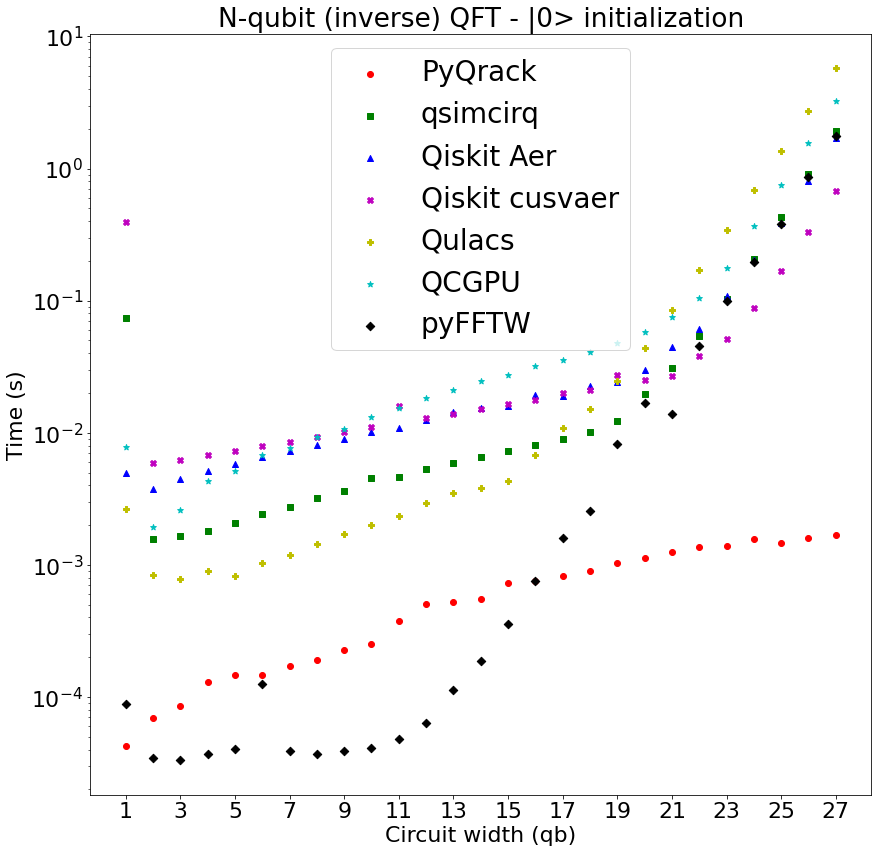

In [22]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qsimcirq_0_results.keys()
y = qsimcirq_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_0_results.keys()
y = aer_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = cusvaer_0_results.keys()
y = cusvaer_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_0_results.keys()
y = qulacs_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_0_results.keys()
y = qcgpu_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit (inverse) QFT - |0> initialization")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack", "qsimcirq", "Qiskit Aer", "Qiskit cusvaer", "Qulacs", "QCGPU", "pyFFTW"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_0_chart.png', dpi=100)

### GHZ initialization

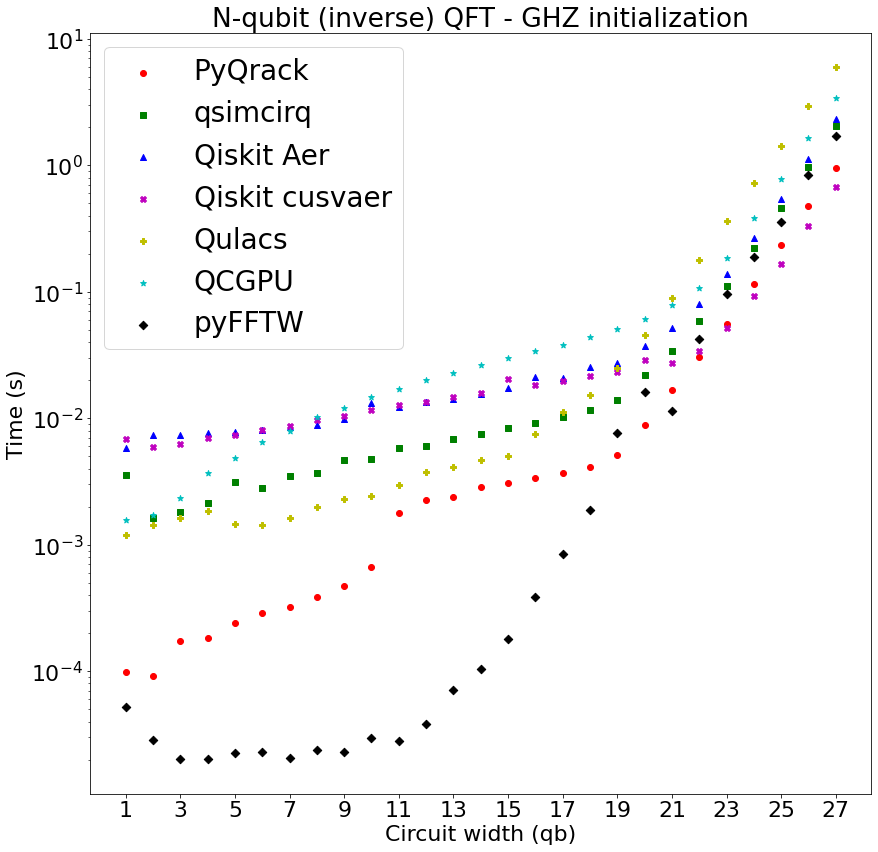

In [23]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_ghz_results.keys()
y = qrack_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qsimcirq_ghz_results.keys()
y = qsimcirq_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_ghz_results.keys()
y = aer_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = cusvaer_ghz_results.keys()
y = cusvaer_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_ghz_results.keys()
y = qulacs_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_ghz_results.keys()
y = qcgpu_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_ghz_results.keys()
y = fftw_ghz_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit (inverse) QFT - GHZ initialization")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack", "qsimcirq", "Qiskit Aer", "Qiskit cusvaer", "Qulacs", "QCGPU", "pyFFTW"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_ghz_chart.png', dpi=100)

In [24]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2
Linux-5.19.0-35-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-35-generic', version='#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2', machine='x86_64')
Linux
x86_64


In [25]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [26]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'